In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 25.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import tqdm
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

import sklearn

In [ ]:
import torch
torch.cuda.is_available()

False

# Оглавление



1. [Почему модели на графах работают?](#p1)
2. [Обучаем первую Graph Neural Network](#p2)  
    2.1. [Возьмем Cora датсет](#p2_1)  
    2.2. [Строим бейзлайн (без графов)](#p2_2)   
    2.3. [GCN](#p2_3)
3. [Full Train Loop](#p3)  
    3.1. [Распределение числа соседей](#p3_1)   
    3.2. [Neighbor sampler from GraphSage](#p3_2)   
    3.3. [Batching](#p3_3)  
    3.4. [Train functions](#p3_4)  
    3.5. [Scheduler](#p3_5)  
    3.6. [GraphSage convolution](#p3_6)  
    3.7. [RUN](#p3_7)   
4. [Более реальный пример](#p4)  
    4.1. [Preprocessing numeric features](#p4_1)  
    4.2. [Yelp Dataset](#p4_2)  
5. [Usefull links](#p5)  

# 1. Почему модели на графах работают? <a name="p1"></a>

Рассмотрим задачу классификации

In [ ]:
def describe_data(data):
    print('========================')

    print(f'Number of nodes: {data.x.shape[0]}')
    print(f'Number of edges: {data.edge_index.shape[1]}')
    print(f'Number of features: {data.x.shape[1]}')

    if data.edge_attr is not None:
        print(f'Number of edge attributes: {data.edge_attr.shape[1]}')

    y = data.y.numpy()
    y = y[~np.isnan(y) & (y!=-100)]
    print(f'Number of classes: {len(np.unique(y))}')
    print('========================')

In [ ]:
def visualize_graph(G, color, title=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    plt.title(title)
#     plt.show()

In [ ]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()

In [ ]:
karate_club = dataset[0]
describe_data(karate_club)

Number of nodes: 34
Number of edges: 156
Number of features: 34
Number of classes: 4


In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx

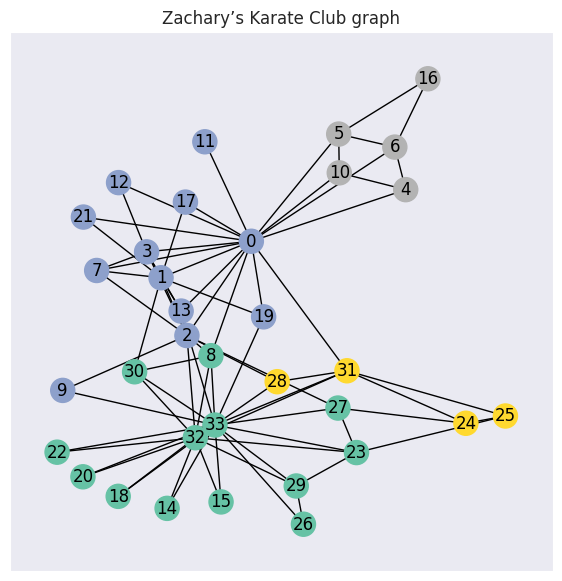

In [ ]:
# Convert the PyG graph to NetworkX graph
G = to_networkx(karate_club, to_undirected=True)
visualize_graph(G, color=karate_club.y, title='Zachary’s Karate Club graph');

# 2. Обучаем первую Graph Neural Network <a name="p2"></a>

Используем Pytorch Geometric library  
https://pyg.org/  
https://pytorch-geometric.readthedocs.io/en/latest/

### 2.1. Возьмем Cora датсет <a name="p2_1"></a>

In [ ]:
from torch_geometric.datasets import Planetoid

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]

Processing...
Done!


In [ ]:
describe_data(data)

Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7


In [ ]:
# data - это основной объект хранения данных в PyG
# x, edge_index, y - основные атрибуты
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

### 2.2. Строим бейзлайн (без графов) <a name="p2_2"></a>

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

def get_log_reg_metric(data):
    from sklearn.linear_model import LogisticRegression
    X_train = data.x[data.train_mask].numpy()
    X_test = data.x[data.test_mask].numpy()

    y_train = data.y[data.train_mask].numpy()
    y_test = data.y[data.test_mask].numpy()

    model = LogisticRegression(C=1)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test).argmax(axis=1)

    return accuracy_score(y_test, y_pred)


def get_lgb_metric(data):
    from lightgbm import LGBMClassifier
    X_train = data.x[data.train_mask].numpy()
    X_test = data.x[data.test_mask].numpy()

    y_train = data.y[data.train_mask].numpy()
    y_test = data.y[data.test_mask].numpy()

    model = LGBMClassifier(n_estimators=50, learning_rate=0.07, verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test).argmax(axis=1)

    return accuracy_score(y_test, y_pred)


def get_MLP_metric(data):
    import torch
    from torch.nn import Linear
    import torch.nn.functional as F

    class MLP(torch.nn.Module):
        def __init__(self, hidden_channels):
            super().__init__()
            torch.manual_seed(12345)
            self.lin1 = Linear(dataset.num_features, hidden_channels)
            self.lin2 = Linear(hidden_channels, dataset.num_classes)

        def forward(self, x):
            x = self.lin1(x)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.lin2(x)
            return x

    model = MLP(hidden_channels=32)
    criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

    def train():
        model.train()
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x[data.train_mask])  # Perform a single forward pass.
        loss = criterion(out, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        return loss

    def test():
        model.eval()
        out = model(data.x[data.test_mask])
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        test_correct = pred == data.y[data.test_mask]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
        return test_acc

    for epoch in range(1, 201):
        loss = train()
    #     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    return test()




def get_baselines_accuracy(data):
    return {
            'MLP': round(get_MLP_metric(data),2),
            'LogReg': round(get_log_reg_metric(data),2),
            'LGB': round(get_lgb_metric(data),2),
           }

In [ ]:
get_baselines_accuracy(data)

{'MLP': 0.58, 'LogReg': 0.57, 'LGB': 0.33}

## 2.3. GCN <a name="p2_3"></a>

[SEMI-SUPERVISED CLASSIFICATION WITH GRAPH CONVOLUTIONAL NETWORKS](https://arxiv.org/abs/1609.02907.pdf) Thomas N. Kipf,
Max Welling

$$\large\mathbf{x}^{\prime}_i = \mathbf{\Theta}^{\top} \sum_{j \in
\mathcal{N}(i) \cup \{ i \}} \frac{1}{\sqrt{\hat{d}_j
\hat{d}_i}} \mathbf{x}_j
$$

где $\hat{d}_i $ - степень $i$-вершины $+ 1$

### Интерактивный пример

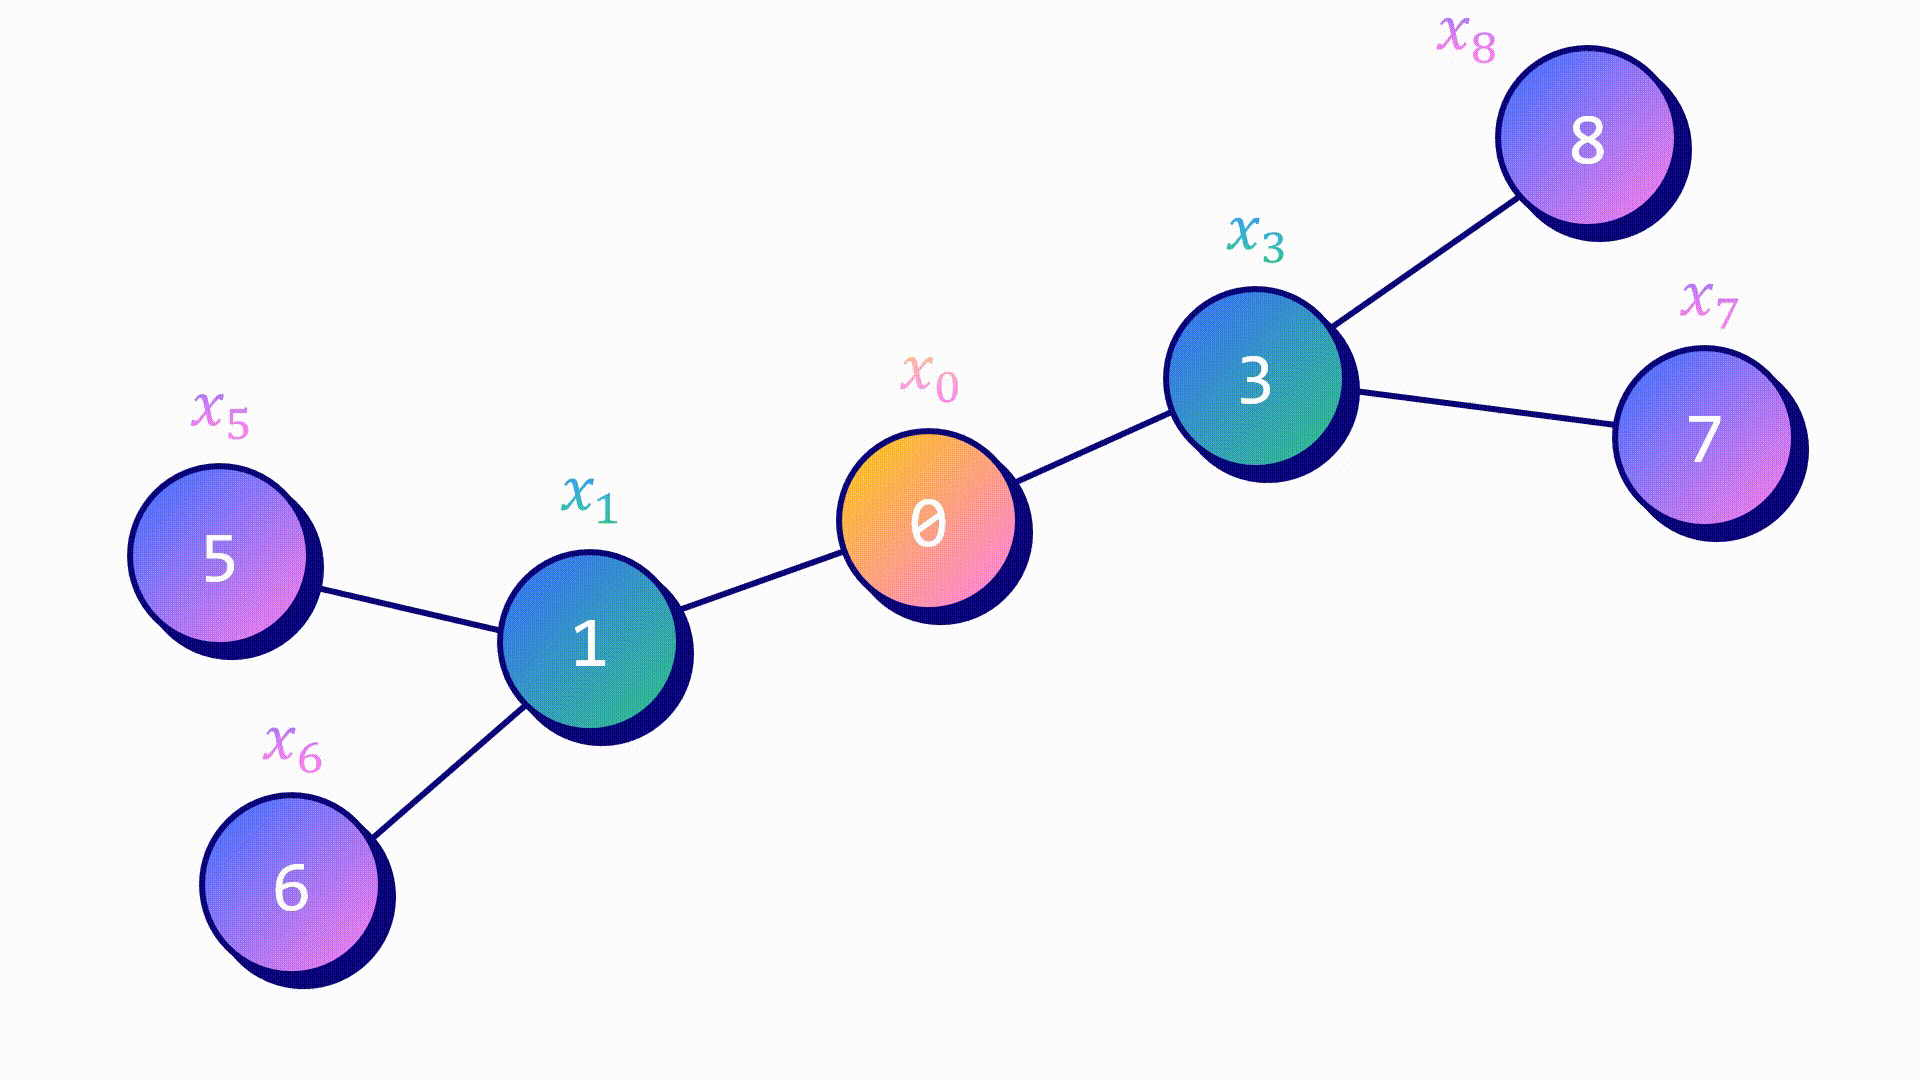

In [ ]:
from torch_geometric.nn import GCN

In [ ]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
model = GCN(in_channels=data.x.shape[1],
            num_layers = 2,
            hidden_channels=16,
            out_channels=data.y.unique().shape[0])

In [ ]:
model

GCN(1433, 7, num_layers=2)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc


for epoch in range(1, 101):
    loss = train()
#     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    test_acc = test()
    print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.4360
Test Accuracy: 0.5850
Test Accuracy: 0.6150
Test Accuracy: 0.5810
Test Accuracy: 0.5720
Test Accuracy: 0.5900
Test Accuracy: 0.6270
Test Accuracy: 0.6600
Test Accuracy: 0.7010
Test Accuracy: 0.7330
Test Accuracy: 0.7520
Test Accuracy: 0.7680
Test Accuracy: 0.7740
Test Accuracy: 0.7830
Test Accuracy: 0.7910
Test Accuracy: 0.7950
Test Accuracy: 0.7960
Test Accuracy: 0.7940
Test Accuracy: 0.7930
Test Accuracy: 0.7950
Test Accuracy: 0.7920
Test Accuracy: 0.7890
Test Accuracy: 0.7890
Test Accuracy: 0.7890
Test Accuracy: 0.7870
Test Accuracy: 0.7860
Test Accuracy: 0.7840
Test Accuracy: 0.7860
Test Accuracy: 0.7860
Test Accuracy: 0.7870
Test Accuracy: 0.7870
Test Accuracy: 0.7850
Test Accuracy: 0.7860
Test Accuracy: 0.7860
Test Accuracy: 0.7860
Test Accuracy: 0.7860
Test Accuracy: 0.7900
Test Accuracy: 0.7890
Test Accuracy: 0.7910
Test Accuracy: 0.7920
Test Accuracy: 0.7930
Test Accuracy: 0.7940
Test Accuracy: 0.7950
Test Accuracy: 0.7940
Test Accuracy: 0.7940
Test Accur

In [ ]:
test_acc = test()
print(f'GNN Test Accuracy: {test_acc:.4f}')

GNN Test Accuracy: 0.7980


In [ ]:
get_baselines_accuracy(data)

{'MLP': 0.58, 'LogReg': 0.57, 'LGB': 0.33}

ура, GNN оказалась намного лучше бейзлайнов!

# 3. Full Train Loop <a name="p3"></a>

### 3.1. Распределение числа соседей <a name="p3_1"></a>

In [ ]:
from torch_geometric.datasets import Amazon
dataset = Amazon(root='data/Amazon', name='Computers')

Processing...
Done!


In [ ]:
from torch_geometric.datasets import Amazon

dataset = Amazon(root='data/Amazon', name='Computers')
data = dataset[0]

describe_data(data)

Number of nodes: 13752
Number of edges: 491722
Number of features: 767
Number of classes: 10


In [ ]:
# считаем число соседей на вершину
df_cnt_neigbbors  = pd.DataFrame(data.edge_index.T.numpy()).groupby(1)[0].count()#.hist(bins=40);

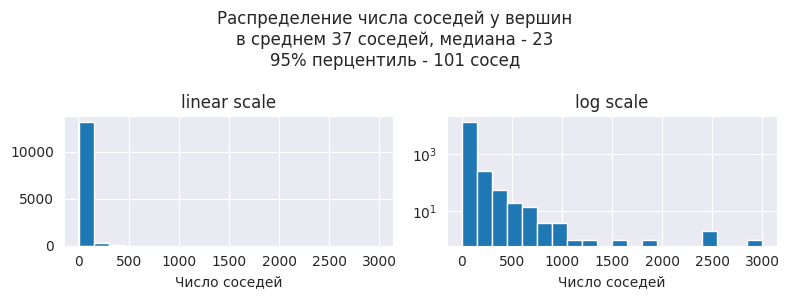

In [ ]:
n_bins = 20
x = df_cnt_neigbbors.values
fig, axs = plt.subplots(1, 2, tight_layout=True)#, sharey=True, tight_layout=True
fig.set_figheight(3)
fig.set_figwidth(8)

ax = axs[0]
ax.hist(x, bins=n_bins)
ax.set_xlabel('Число соседей')
ax.set_title('linear scale')

ax = axs[1]
ax.hist(x, bins=n_bins)
ax.set_xlabel('Число соседей')
ax.set_yscale('log')
ax.set_title('log scale')

fig.suptitle(f'''Распределение числа соседей у вершин
в среднем {x.mean():.0f} соседей, медиана - {np.median(x):.0f}
95% перцентиль - {np.quantile(x,q=0.95):.0f} сосед''');

У распределения тяжелые хвосты.

Это может сильно увеличить время расчета и привести к нестабильности при использовании, например, агрегирующей фукнции SUM
в таких случаях используется метод предложенный в статье:

[GraphSAGE: Inductive Representation Learning on Large Graphs](https://arxiv.org/abs/1706.02216), William L. Hamilton, Rex Ying, Jure Leskovec

### 3.2. Neighbor sampler from GraphSage <a name="p3_2"></a>

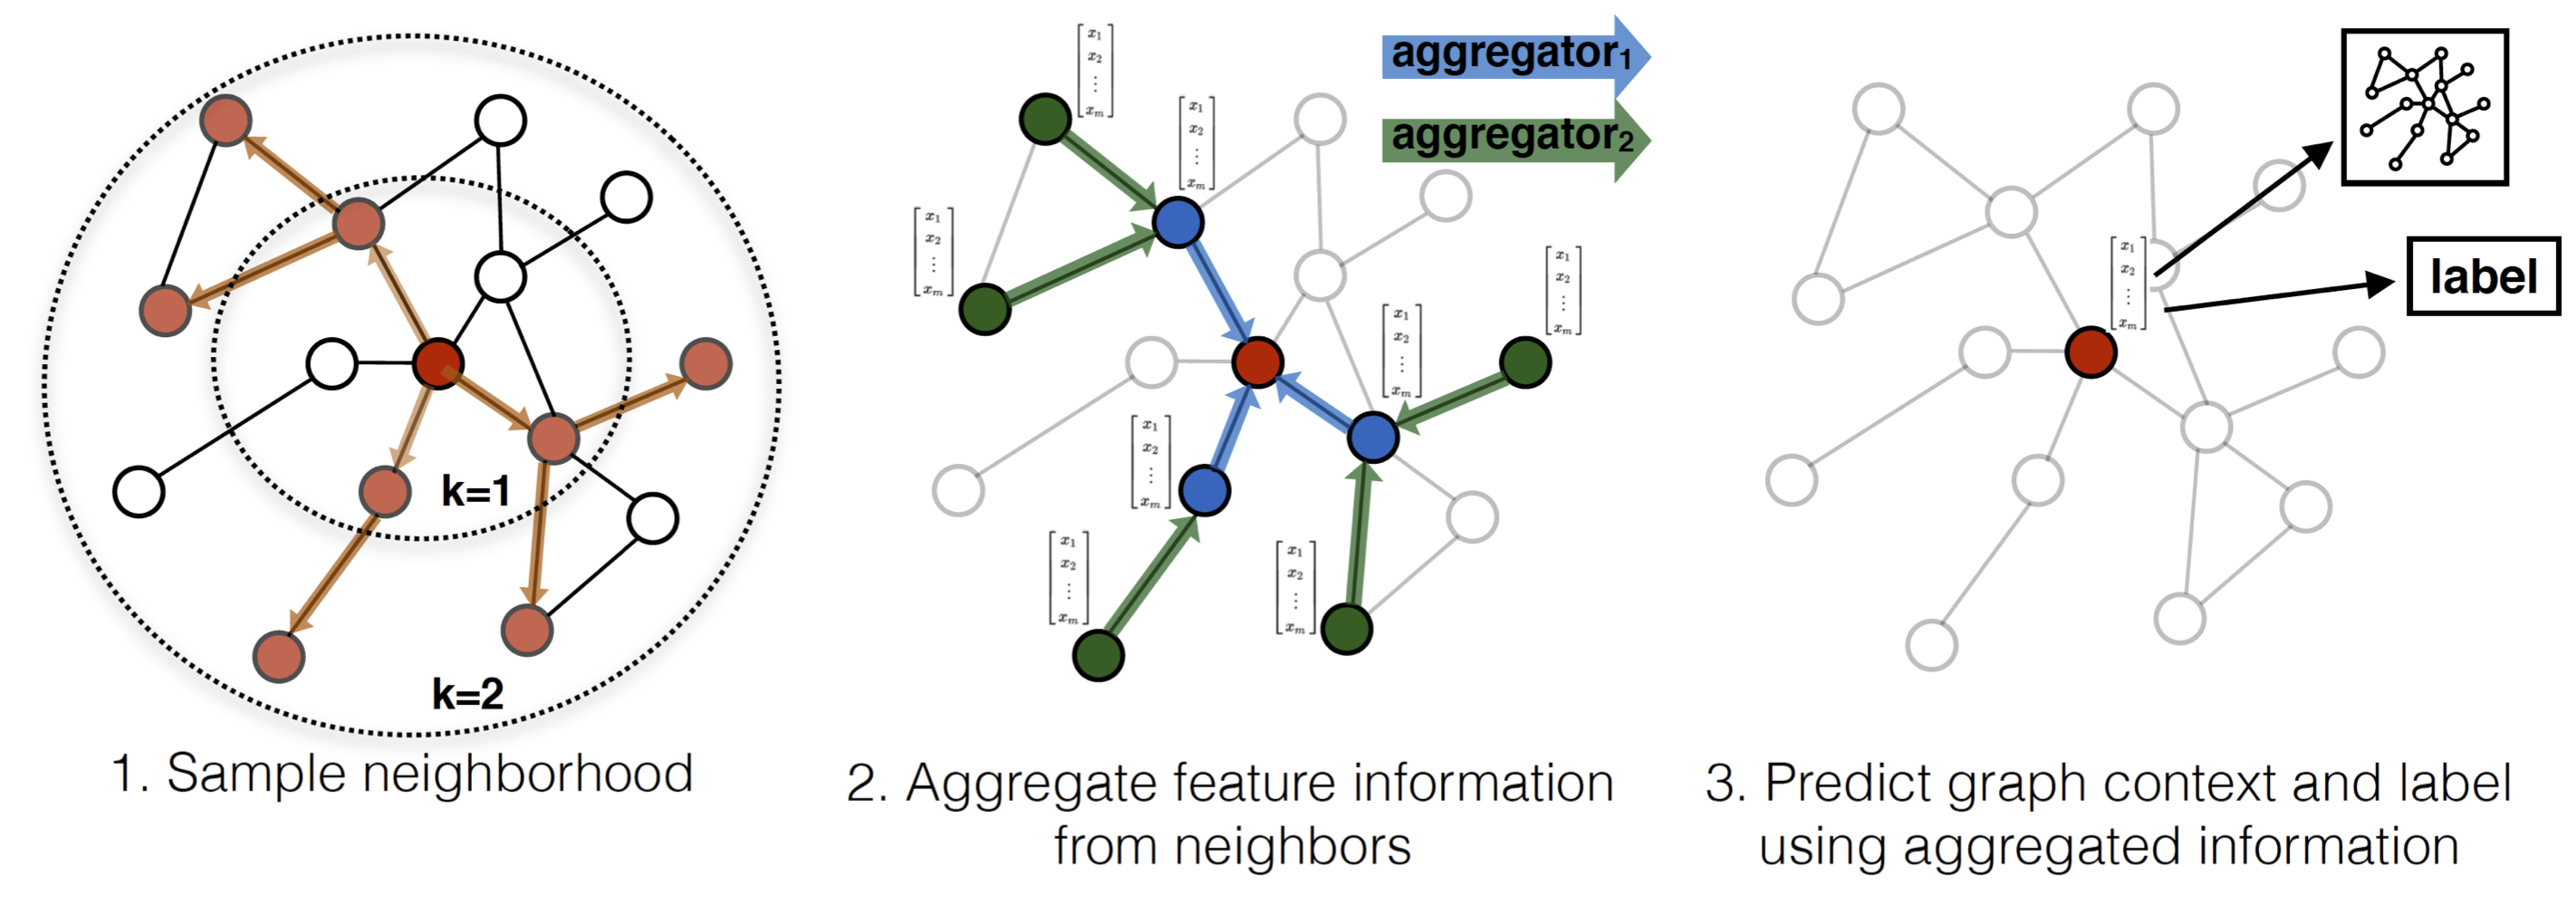

### 3.3. Batching <a name="p3_3"></a>

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_idx, test_idx = train_test_split(torch.arange(len(data.x)), test_size=0.25, random_state=42)

In [ ]:
# # Доли классов
# pd.Series(data.y.numpy()).value_counts(normalize=True)

In [ ]:
from torch_geometric.loader import NeighborSampler, NeighborLoader
from torch_geometric.data import Data

loader_train = NeighborLoader(
    data,
    num_neighbors=[20, 10],
    batch_size=250,
    shuffle=False,
    input_nodes=train_idx,
)


loader_test = NeighborLoader(
    data,
    num_neighbors=[20, 10],
    batch_size=250,
    shuffle=False,
    input_nodes=test_idx,
)



/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [ ]:
# Это генератор
type(loader_train)

torch_geometric.loader.neighbor_loader.NeighborLoader

In [ ]:
%%time
# Обычно лучше предрасчитать разбиение на батчи, так как это ресурсоемкий процес
loader_train = list(loader_train)

CPU times: user 2.59 s, sys: 1.1 s, total: 3.69 s
Wall time: 3.71 s


In [ ]:
print('Число батчей:',len(loader_train))

Число батчей: 42


In [ ]:
data_batch = loader_train[0]

In [ ]:
data_batch

Data(x=[8834, 767], edge_index=[2, 28826], y=[8834], n_id=[8834], e_id=[28826], input_id=[250], batch_size=250)

In [ ]:
data_batch

Data(x=[8834, 767], edge_index=[2, 28826], y=[8834], n_id=[8834], e_id=[28826], input_id=[250], batch_size=250)

In [ ]:
data

Data(x=[13752, 767], edge_index=[2, 491722], y=[13752])

In [ ]:
print('Число вершин в батче меньше в {:.1f} раз'.format(data.x.shape[0]/ data_batch.x.shape[0]))
print('Число ребер в батче меньше  в {:.1f} раз'.format(data.edge_index.shape[1]/ data_batch.edge_index.shape[1]))

Число вершин в батче меньше в 1.6 раз
Число ребер в батче меньше  в 17.1 раз


In [ ]:
describe_data(data)

Number of nodes: 13752
Number of edges: 491722
Number of features: 767
Number of classes: 10


### 3.4 Train functions <a name="p3_4"></a>

In [ ]:
def train(model, loader, criterion, device, optimizer, scheduler=None, tqdm_disable=True):
    """
    train model for 1 epoch
    """
    start_time = time.time()

    model.train()
    total_loss = 0

    for data_batch in tqdm.tqdm(loader, leave=False, disable=tqdm_disable):
        sampled_data = data_batch.clone().to(device)

        optimizer.zero_grad()
        out = model(x = sampled_data.x, edge_index = sampled_data.edge_index)
        loss = criterion(out[:sampled_data.batch_size], sampled_data.y[:sampled_data.batch_size])
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        total_loss += loss.detach().item() / len(loader)

    if scheduler is not None:
        scheduler.step()

    calc_time = time.time() - start_time
    return total_loss, calc_time

In [ ]:
def test(model, loader, device, tqdm_disable=True):
    """
    eval model
    """
    start_time = time.time()

    model.eval()

    ys = []
    outs = []

    with torch.no_grad():
        for data_batch in tqdm.tqdm(loader, leave=False, disable=tqdm_disable):
            sampled_data = data_batch.clone().to(device)

            out = model(x = sampled_data.x, edge_index = sampled_data.edge_index).detach()
            ys.append(sampled_data.y[:sampled_data.batch_size].cpu())
            outs.append(out[:sampled_data.batch_size].cpu())


    out = torch.cat(outs, dim=0)
    y = torch.cat(ys)

    y_pred = out.argmax(dim=1)

    calc_time = time.time() - start_time

    # accuracy
    return (y==y_pred).float().mean().item()

### 3.5. Scheduler <a name="p3_5"></a>

Examples:  
$\text{lr_scheduler.MultiStepLR}$ - Decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.    
$\text{lr_scheduler.ReduceLROnPlateau}$ - Reduce learning rate when a metric has stopped improving.

scheduler = torch.optim.lr_scheduler.MultiStepLR(  
        optimizer = optimizer,  
        milestones =  [20, 50, 90],  
        gamma = 0.1)

For more details look at [torch docs](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

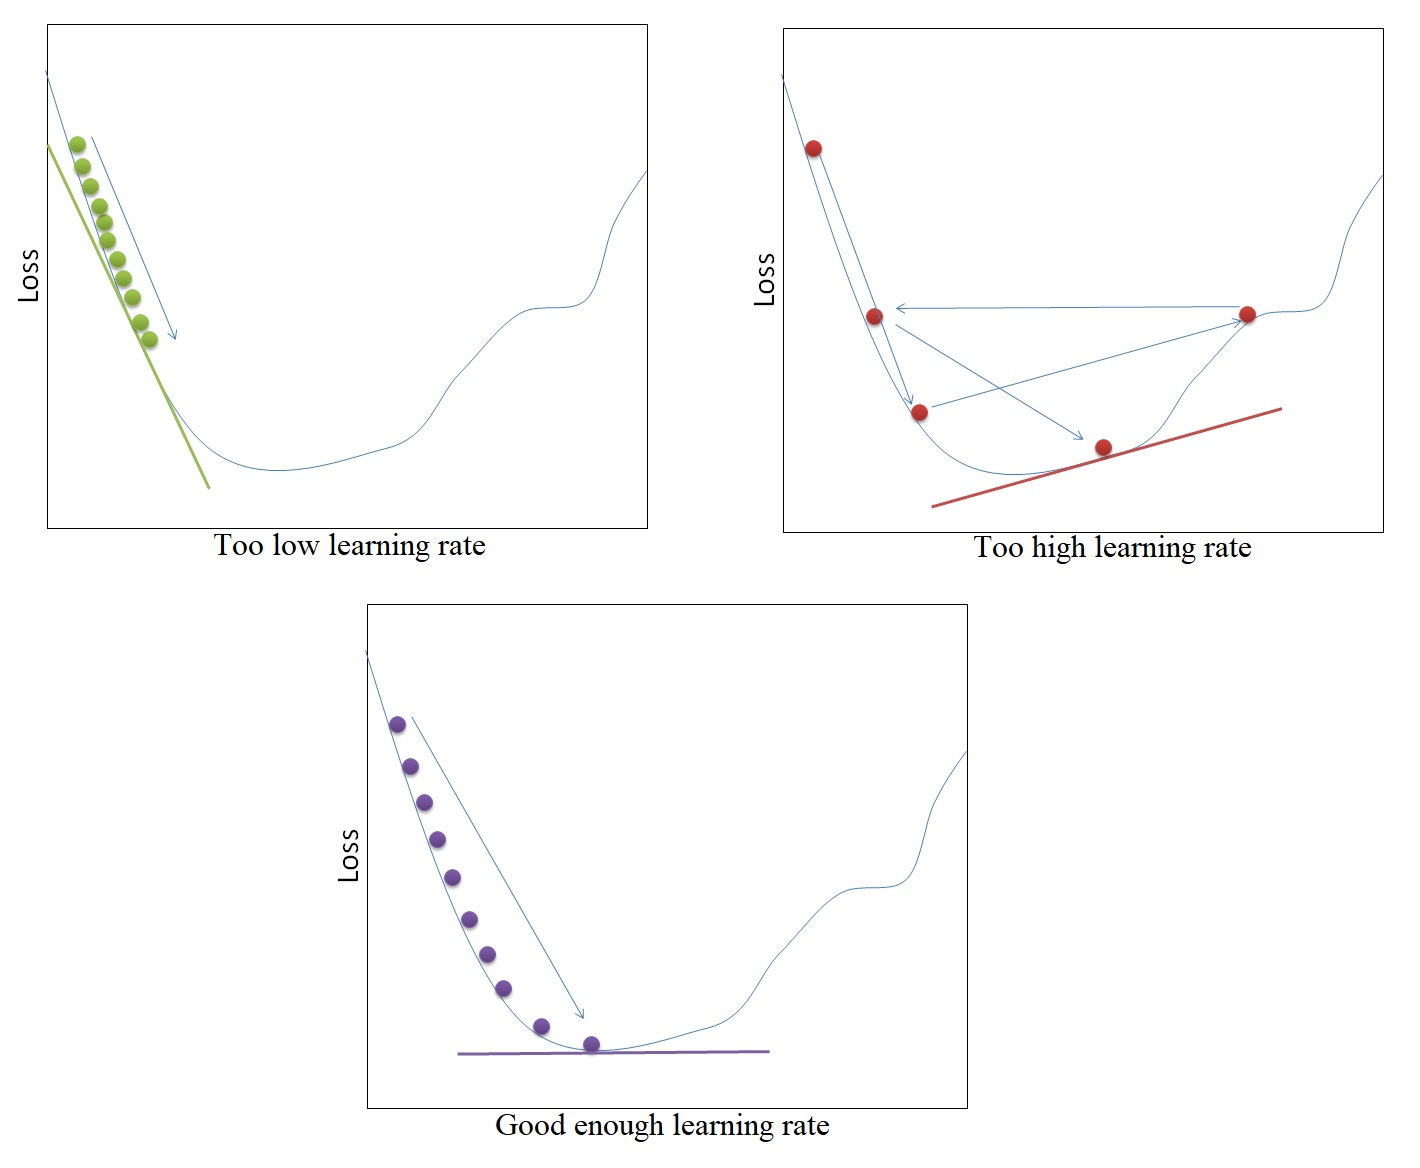

### 3.6. GraphSage convolution <a name="p3_6"></a>

$$\large\mathbf{x}^{\prime}_i = \mathbf{W}_1 \mathbf{x}_i + \mathbf{W}_2 \cdot
\mathrm{mean}_{j \in \mathcal{N(i)}} \mathbf{x}_j$$

from [GraphSAGE: Inductive Representation Learning on Large Graphs](https://arxiv.org/abs/1706.02216), William L. Hamilton, Rex Ying, Jure Leskovec

for more convlolution visit https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers

In [ ]:
from torch_geometric.nn import SAGEConv
from torch.nn import Linear, Dropout, ReLU
import torch.nn.functional as F

In [ ]:
class SAGE(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SAGE, self).__init__()
        torch.manual_seed(420)
        self.conv1 = SAGEConv(in_channels = input_size,
                              out_channels = hidden_size,
                              aggr='mean')
        self.act1 = ReLU()
        self.dropout1 = Dropout(0.5)

        self.conv2 = SAGEConv(in_channels = hidden_size,
                              out_channels = output_size,
                              aggr='mean')


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act1(x)
        x = self.dropout1(x)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
input_size = data.x.shape[1]
output_size = data.y.unique().shape[0]

hidden_size = 64

In [ ]:
model = SAGE(input_size, hidden_size, output_size)

In [ ]:
model

SAGE(
  (conv1): SAGEConv(767, 64, aggr=mean)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): SAGEConv(64, 10, aggr=mean)
)

In [ ]:
model.conv1.lin_l, model.conv1.lin_r

(Linear(767, 64, bias=True), Linear(767, 64, bias=False))

In [ ]:
model.conv2.lin_l, model.conv2.lin_r

(Linear(64, 10, bias=True), Linear(64, 10, bias=False))

### 3.7. RUN <a name="p3_7"></a>

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer = optimizer,
    milestones =  [15, 30],
    gamma = 0.25)

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
n_epochs = 50
for epoch in range(1, n_epochs+1):
    total_loss, calc_time = train(model, loader_train, criterion, device, optimizer, tqdm_disable=False)
    test_acc = test(model, loader_test, device, tqdm_disable=False)
    train_acc = test(model, loader_train, device, tqdm_disable=False)
    print(f'Epcoh:{epoch:03d} TrainLoss : {total_loss:.3f}, Train Accuracy : {train_acc:.3f}, Test Accuracy : {test_acc:.3f}',
          file=sys.stderr)

Epcoh:001 TrainLoss : 2.192, Train Accuracy : 0.746, Test Accuracy : 0.762
Epcoh:002 TrainLoss : 0.649, Train Accuracy : 0.815, Test Accuracy : 0.807
Epcoh:003 TrainLoss : 0.541, Train Accuracy : 0.871, Test Accuracy : 0.869
Epcoh:004 TrainLoss : 0.502, Train Accuracy : 0.866, Test Accuracy : 0.860
Epcoh:005 TrainLoss : 0.464, Train Accuracy : 0.887, Test Accuracy : 0.880
Epcoh:006 TrainLoss : 0.456, Train Accuracy : 0.894, Test Accuracy : 0.882
Epcoh:007 TrainLoss : 0.422, Train Accuracy : 0.896, Test Accuracy : 0.881
Epcoh:008 TrainLoss : 0.453, Train Accuracy : 0.866, Test Accuracy : 0.857
Epcoh:009 TrainLoss : 0.408, Train Accuracy : 0.887, Test Accuracy : 0.870
Epcoh:010 TrainLoss : 0.431, Train Accuracy : 0.896, Test Accuracy : 0.884
Epcoh:011 TrainLoss : 0.393, Train Accuracy : 0.892, Test Accuracy : 0.869
Epcoh:012 TrainLoss : 0.415, Train Accuracy : 0.902, Test Accuracy : 0.889
Epcoh:013 TrainLoss : 0.422, Train Accuracy : 0.899, Test Accuracy : 0.878
Epcoh:014 TrainLoss : 0.4

KeyboardInterrupt: ignored

In [ ]:
print('Test Accuracy : {:.3f}'.format(test(model, loader_test, device)))

Test Accuracy : 0.882


In [ ]:
# baseline
data.train_mask = torch.zeros_like(data.y, dtype=bool)
data.train_mask[train_idx] = True
data.test_mask =  torch.zeros_like(data.y, dtype=bool)
data.test_mask[test_idx] = True

get_baselines_accuracy(data)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'MLP': 0.74, 'LogReg': 0.83, 'LGB': 0.86}

In [ ]:
data.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 1., 1., 0.]])

# 4. Более реальный пример <a name="p4"></a>

### 4.1. Preprocessing numeric features <a name="p4_1"></a>

В отличие от бустинга, где важен лишь относительный порядок для фичей, линейные модели и нейросети очень чувствительны к распрделению входных фичей

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
dataset = fetch_california_housing(data_home='./data/california_housing')
df = pd.DataFrame(dataset.data,columns=dataset.feature_names)
x = df[['Population']] #население географической единицы

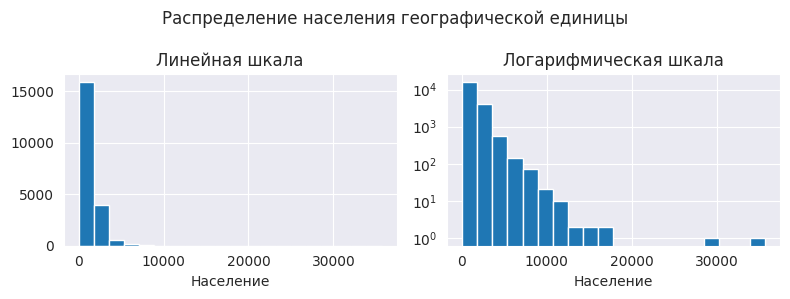

In [ ]:
n_bins = 20
fig, axs = plt.subplots(1, 2, tight_layout=True)#, sharey=True, tight_layout=True
fig.set_figheight(3)
fig.set_figwidth(8)

ax = axs[0]
ax.hist(x.values, bins=n_bins)
ax.set_xlabel('Население')
ax.set_title('Линейная шкала')

ax = axs[1]
ax.hist(x.values, bins=n_bins)
ax.set_xlabel('Население')
ax.set_yscale('log')
ax.set_title('Логарифмическая шкала')

fig.suptitle('Распределение населения географической единицы');

распрделение имеет тяжелые хвосты

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer

In [ ]:
x = x.values
x.shape

(20640, 1)

In [ ]:
res = {}

res['Original'] = x[:,0]

res['MinMaxScaler'] = MinMaxScaler().fit_transform(x)[:,0]

res['StandardScaler'] = StandardScaler().fit_transform(x)[:,0]

res['log + StandardScaler'] = StandardScaler().fit_transform( np.log10(x+1) )[:,0]

res['QuantileTransformer'] = QuantileTransformer(output_distribution='uniform').fit_transform(x)[:,0]

# Gauss Rank Transformation
res['GaussRankTransformer'] = QuantileTransformer(output_distribution='normal').fit_transform(x)[:,0]

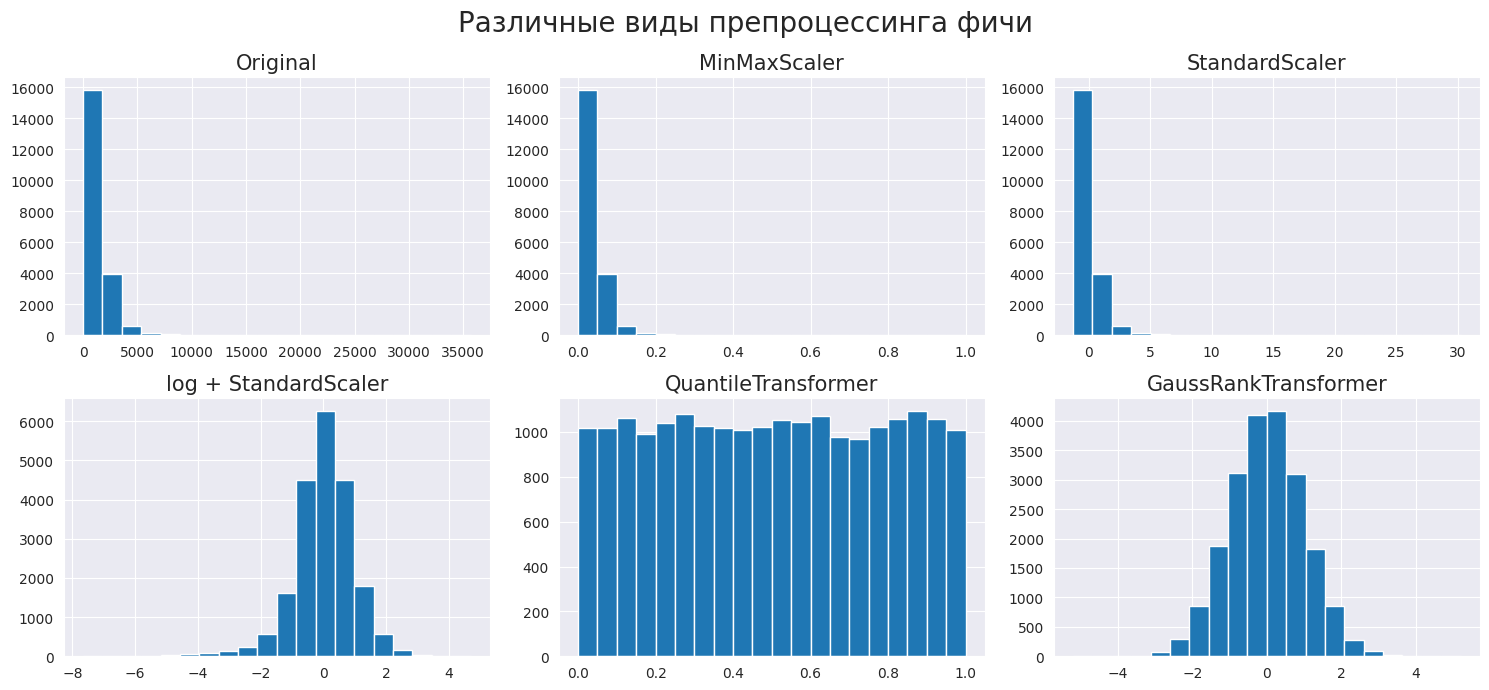

In [ ]:
n_bins = 20
rows, cols = 2, 3
fig, axs = plt.subplots(rows, cols, tight_layout=True)#, sharey=True, tight_layout=True
fig.set_figheight(7)
fig.set_figwidth(15)
for k, (name, values) in enumerate(res.items()):
    ax = axs[k//cols,k%cols]
    ax.hist(values, bins=n_bins)
    ax.set_title(name, fontsize=15)

fig.suptitle('Различные виды препроцессинга фичи', fontsize=20);

### Как работает Gauss Rank Transformation?

1. Считаем ранг каждого значения фичи -> получаем массив целых чисел [1..n]
2. Масштабируем к [0,1] -> Здесь получаем равномерное распрделение U(0,1)
3. Применяем обраную функции к функции нормального распределения -> получаем нормальное распределение N(0,1)


### Если много нулевых значений?

часто бывает, что с одной стороны распределение имеет тяжелые хвосты, с другой стороны много нулевых значений

Тогда нулевые значения можно оставить неподвижными, а остальные значения преобразовать в правую половину гауссианы

In [ ]:
# добавим столько же нулей
x_new = np.vstack([x, np.zeros(shape=(x.shape[0] // 2, 1))])

In [ ]:
from scipy import stats

In [ ]:
res = {}

res['Original'] = x_new[:,0]

res['log + StandardScaler'] = StandardScaler().fit_transform( np.log10(x_new+1) )[:,0]

res['QuantileTransformer'] = QuantileTransformer(output_distribution='uniform').fit_transform(x_new)[:,0]

res['GaussRankTransformer'] = QuantileTransformer(output_distribution='normal').fit_transform(x_new)[:,0]

scaler = QuantileTransformer(output_distribution='uniform')
where = x_new[:,0] != 0
x_uniform = scaler.fit_transform(x_new[where])[:,0]
x_norm = stats.norm.ppf(np.clip(x_uniform*0.5 +0.5, 1e-4,1-1e-4))
x_out = np.zeros_like(x_new[:,0])
x_out[where] = x_norm

res['Half GaussRankTransformer'] = x_out

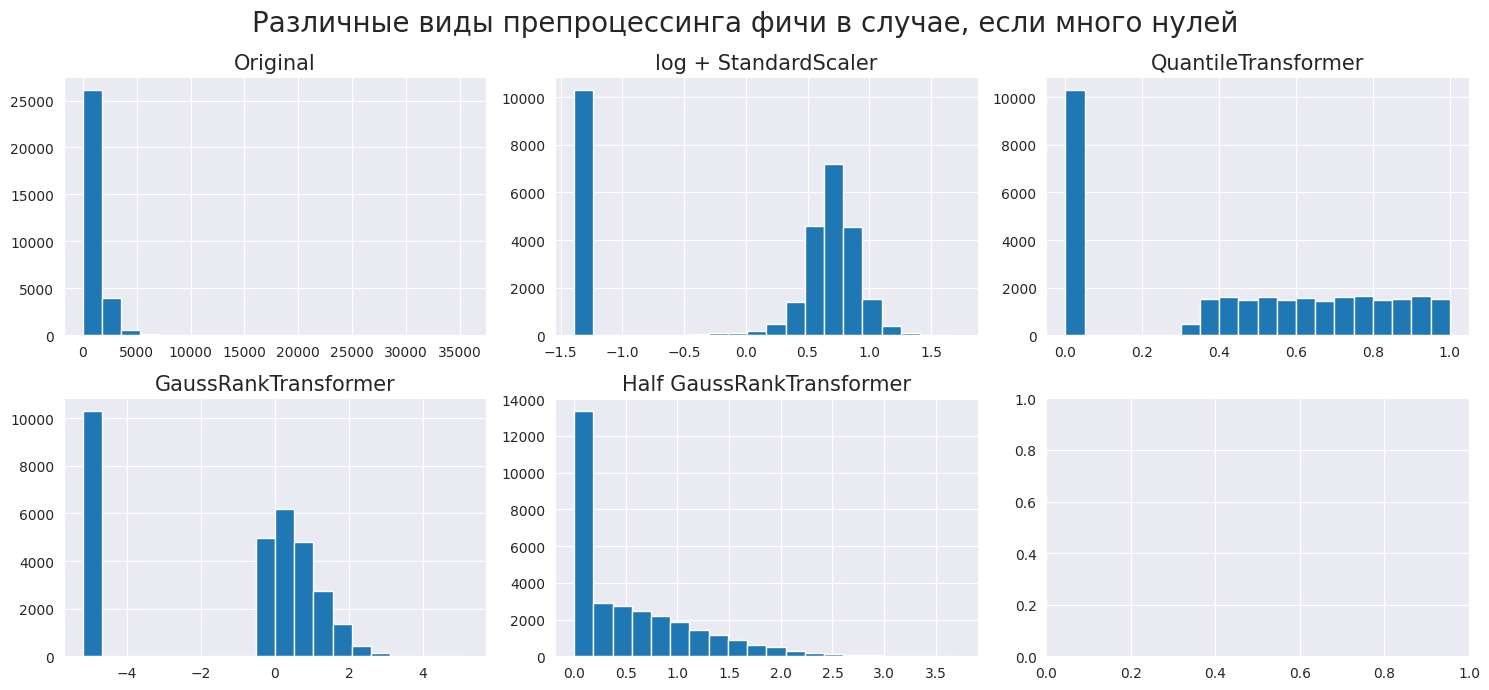

In [ ]:
n_bins = 20
rows, cols = 2, 3
fig, axs = plt.subplots(rows, cols, tight_layout=True)#, sharey=True, tight_layout=True
fig.set_figheight(7)
fig.set_figwidth(15)
for k, (name, values) in enumerate(res.items()):
    ax = axs[k//cols,k%cols]
    ax.hist(values, bins=n_bins)
    ax.set_title(name, fontsize=15)

fig.suptitle('Различные виды препроцессинга фичи в случае, если много нулей', fontsize=20);

### 4.2. Yelp Dataset <a name="p4_2"></a>

In [ ]:
%%time
from torch_geometric.datasets import Yelp
dataset = Yelp(root='data/Yelp')

Processing...
Done!


CPU times: user 38 s, sys: 14.9 s, total: 52.9 s
Wall time: 1min 22s


In [ ]:
data = dataset[0]

In [ ]:
data.x

tensor([[-0.1099,  0.6558,  0.6379,  ..., -0.9956,  0.7760, -0.4105],
        [ 0.1312,  0.7940,  0.8931,  ..., -0.5271,  0.6866, -0.7837],
        [ 0.8454,  0.6010,  0.5898,  ..., -0.3750,  0.8268, -0.4899],
        ...,
        [-0.0935,  0.8956,  0.7136,  ..., -0.7860,  0.8488, -1.1589],
        [ 0.4001,  0.6038,  0.7244,  ..., -0.7595,  1.1091, -0.7599],
        [ 0.0641,  0.7803,  0.8644,  ..., -0.7815,  1.0045, -0.5819]])

In [ ]:
# Мультитаргет классификация - 100 tasks
data.y[0,:]

tensor([1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

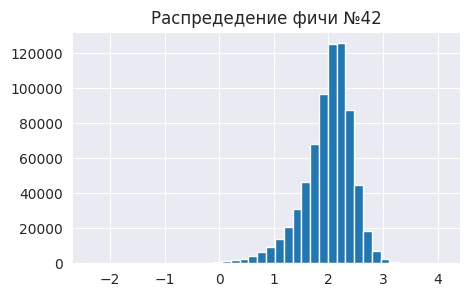

In [ ]:
plt.figure(figsize=(5,3))
plt.hist(data.x[:,42].numpy(), bins=40);
plt.title('Распредедение фичи №42');

In [ ]:
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer

### Препроцессинг фичей

In [ ]:
1

1

In [ ]:
%%time

scaler = QuantileTransformer(output_distribution='normal')

data.x = torch.FloatTensor(scaler.fit_transform(data.x.numpy()))

In [ ]:
data

Data(x=[716847, 300], edge_index=[2, 13954819], y=[716847, 100], train_mask=[716847], val_mask=[716847], test_mask=[716847])

In [ ]:
# датасет очень большой, придется бить на батчи

In [ ]:
from torch_geometric.loader import NeighborSampler, NeighborLoader
from torch_geometric.data import Data

loader_train = NeighborLoader(
    data,
    num_neighbors=[30, 15],
    batch_size=1000,
    shuffle=True,
    input_nodes=data.train_mask,
#    num_workers=4
)

loader_test = NeighborLoader(
    data,
    num_neighbors=[30, 15],
    batch_size=1000,
    shuffle=False,
    input_nodes=data.test_mask,
#    num_workers=4
)
# к сожалению, придется пользоваться генератором, так как объем RAM весьма ограничен

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [ ]:
input_size = data.x.shape[1]
output_size = data.y.shape[1]

hidden_size = 200

model = SAGE(input_size, hidden_size, output_size)

In [ ]:
model

SAGE(
  (conv1): SAGEConv(300, 200, aggr=mean)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): SAGEConv(200, 100, aggr=mean)
)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer = optimizer,
    milestones =  [15, 30],
    gamma = 0.1)

criterion = torch.nn.BCEWithLogitsLoss() # Binary Cross Entropy after Sigmoid

In [ ]:
def test_mt(model, loader, device, tqdm_disable=True):
    """
    eval multitarget model
    """
    start_time = time.time()
    model.eval()
    ys = []
    outs = []
    with torch.no_grad():
        for data_batch in tqdm.tqdm(loader, leave=False, disable=tqdm_disable):
            sampled_data = data_batch.clone().to(device)

            out = model(x = sampled_data.x, edge_index = sampled_data.edge_index).detach()
            ys.append(sampled_data.y[:sampled_data.batch_size].cpu())
            outs.append(out[:sampled_data.batch_size].cpu())
    out = torch.cat(outs, dim=0)
    y = torch.cat(ys).numpy()
    y_pred = F.sigmoid(out).numpy()

    n = y.shape[1]
    auc = 0
    for i in range(n):
        auc += roc_auc_score(y[:,i] , y_pred[:,i]) / n

    calc_time = time.time() - start_time

    # accuracy
    return auc

In [ ]:
n_epochs = 50
# 10-15min per epoch
for epoch in range(1, n_epochs + 1):
    total_loss, calc_time = train(model, loader_train, criterion, device, optimizer, tqdm_disable=False)
    test_auc = test_mt(model, loader_test, device, tqdm_disable=False)
    train_auc = test_mt(model, loader_train, device, tqdm_disable=False)
    print(f'Epcoh:{epoch:03d} TrainLoss : {total_loss:.3f}, Train Roc-Auc : {train_auc:.3f}, Test Roc-Auc : {test_auc:.3f}',
          file=sys.stderr)

  5%|▍         | 26/538 [00:37<12:50,  1.50s/it]

# 5. Usefull links <a name="p5"></a>

### articles
[SEMI-SUPERVISED CLASSIFICATION WITH GRAPH CONVOLUTIONAL NETWORKS](https://arxiv.org/abs/1609.02907.pdf) Thomas N. Kipf,
Max Welling  
[GraphSAGE: Inductive Representation Learning on Large Graphs](https://arxiv.org/abs/1706.02216), William L. Hamilton, Rex Ying, Jure Leskovec

### convolutional-layers :
https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers  
https://pytorch-geometric.readthedocs.io/en/latest/cheatsheet/gnn_cheatsheet.html
- GCNConv
- SAGEConv
- GraphConv
- GATConv
- NNConv

### GNN explainer
https://pytorch-geometric.readthedocs.io/en/latest/modules/explain.html